# Road Runner Lite From Scratch

This tutorial walks through the creation of a lite [Road Runner](https://github.com/acmerobotics/road-runner). It aims to cover all of the math and code required for a simple version. The only prerequisite is basic proficiency in single-variable calculus, vectors, and parametric curves at the level of [this Khan Academy unit](https://www.khanacademy.org/math/multivariable-calculus/multivariable-derivatives/position-vector-functions/v/position-vector-valued-functions). The full library is mostly a scaled-up version of these ideas with bells and whistles.

The tutorial is written in Python using NumPy primitives instead of Kotlin. The decorator `vectorize_tail` is occasionally necessary to make functions cooperate with array inputs. You can safely ignore its definition and subsequent uses.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

vectorize_tail = lambda f: np.vectorize(f, excluded={0})

## Trajectories

Let's focus first on moving smoothly in a single dimension. Say we have a robot with position $x$ that we want to move from rest at $x_0$ to rest at $x_1$ (where $x_1 \geq x_0$). We can cast this as the problem of finding a position function $x(t)$ that satisfies $x(0) = x_0$ and $x(T) = x_1$ (where $T \geq 0$). This single function also determines the velocity and acceleration through its derivatives. There are many such functions, so we'll take the minimum-time one that obeys the maximum-velocity constraint $|x'(t)| \leq v_{max}$ for all $0 \leq t \leq T$ (where $v_{max} > 0$). This optimal trajectory is achieved by going full throttle and setting $x'(t) = v_{max}$. We integrate to obtain
\begin{align*}
    x(t) - x(0) &= \int_0^t x'(\tau) \, d\tau = \int_0^t v_{max} \, d\tau = v_{max} t\\
    x(t) &= x_0 + v_{max} t
\end{align*}
where the start position constraint is guaranteed. The end position constraint can be satisfied by choosing the duration
\begin{align*}
    x_1 &= x_0 + v_{max} T\\
    T &= \frac{x_1 - x_0}{v_{max}}.
\end{align*}

The following snippet implements this velocity-limited trajectory generator.

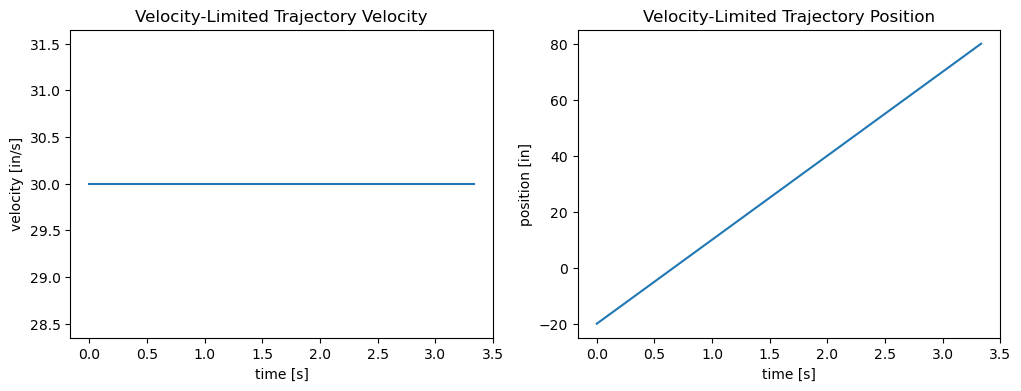

In [2]:
def vel_traj_gen(x0, x1, vmax):
    dt = (x1 - x0) / vmax
    return x0, vmax, dt


traj_x0, traj_v, traj_dt = vel_traj_gen(-20, 80, 30)
t = np.linspace(0, traj_dt, 100)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].set_title('Velocity-Limited Trajectory Velocity')
ax[0].set_xlabel('time [s]')
ax[0].set_ylabel('velocity [in/s]')
ax[0].plot(t, np.full(t.shape, traj_v)) 

ax[1].set_title('Velocity-Limited Trajectory Position')
ax[1].set_xlabel('time [s]')
ax[1].set_ylabel('position [in]')
ax[1].plot(t, traj_x0 + traj_v * t)

But can the robot faithfully execute the generated trajectory? It takes time for the robot to high velocity from rest, and we can command a more realistic plan by incorporating that limitation into our model. We need an acceleration limit $|x''(t)| \leq a_{max}$ for all $0 \leq t \leq T$ (where $a_{max} > 0$) similar to the earlier velocity one. The optimal trajectory for the new setup has multiple distinct phases: acceleration, coast, and deceleration. The first and last phases go full throttle to maximize acceleration, while the second phase maintains the maximum velocity. To keep our calculations succint, we'll use the standard constant-velocity and constant-acceleration formulas. You can derive them from first principles using calculus as we did before.

The first phase has acceleration $a_{max}$, and the duration $\Delta t_1$ satisfies
\begin{align*}
    v_{max} &= 0 + a_{max} \Delta t_1\\
    \Delta t_1 &= \frac{v_{max}}{a_{max}}.
\end{align*}
The third phase has acceleration $-a_{max}$, and the duration $\Delta t_3$ satisfies
\begin{align*}
    0 &= v_{max} - a_{max} \Delta t_3\\
    \Delta t_3 &= \frac{v_{max}}{a_{max}},
\end{align*}
which matches $\Delta t_1$ as expected by symmetry. While the outer phases depend only on the constraints, the middle phase expands to achieve the desired total distance. It relates to the other parameters according to
\begin{align*}
    x_1 &= x_0 + \frac{1}{2} a_{max} \Delta t_1^2 + v_{max} \Delta t_2 + v_{max} \Delta t_3 - \frac{1}{2} a_{max} \Delta t_3^2\\
    &= x_0 + v_{max} \Delta t_2 + \frac{v_{max}^2}{a_{max}}\\
    \Delta t_2 &= \frac{x_1 - x_0}{v_{max}} - \frac{v_{max}}{a_{max}}.
\end{align*}
But this difference expression is suspicious. What if the computed $\Delta t_2$ is negative? The robot might not have enough runway to reach the maximum velocity and goes straight from acceleration into deceleration. Let's leverage the symmetry $\Delta t_1 = \Delta t_3 = \Delta t$ to compute the new phase durations. The duration $\Delta t$ is
\begin{align*}
    x_1 &= x_0 + \frac{1}{2} a_{max} \Delta t_1^2 + v_{max} \Delta t_3 - \frac{1}{2} a_{max} \Delta t_3^2\\
    &= x_0 + \frac{1}{2} a_{max} \Delta t^2 + a_{max} \Delta t^2 - \frac{1}{2} a_{max} \Delta t^2\\
    &= x_0 + a_{max} \Delta t^2\\
    \Delta t &= \sqrt{\frac{x_1 - x_0}{a_{max}}}
\end{align*}

With both the normal and degenerate case covered, we can implement the acceleration-limited trajectory generation.

In [3]:
def accel_traj_gen(x0, x1, vmax, amax):
    dx = x1 - x0
    if vmax / amax < dx / vmax:
        # normal trajectory
        dt1 = vmax / amax
        dt2 = dx / vmax - vmax / amax
        dt3 = dt1
        return x0, (
            (amax, dt1),
            (0, dt2),
            (-amax, dt3)
        )
    else:
        # degenerate trajectory
        dt1 = np.sqrt(dx / amax)
        dt2 = dt1
        return x0, (
            (amax, dt1), 
            (-amax, dt2)
        )

For the trajectory to be useful, we need functions to compute instantaneous values at arbitrary points in time.

In [4]:
@vectorize_tail
def accel_traj_get_accel(traj, t):
    _, phases = traj
    for a, dt in phases:
        if t < dt:
            return a
        
        t -= dt
    return a

        
@vectorize_tail
def accel_traj_get_vel(traj, t):
    _, phases = traj
    v0 = 0
    for a, dt in phases:
        if t < dt:
            return v0 + a * t
        
        v0 += a * dt
        
        t -= dt
    return v0
    
    
@vectorize_tail
def accel_traj_get_pos(traj, t):
    x0, phases = traj
    v0 = 0
    for a, dt in phases:
        if t < dt:
            return x0 + v0 * t + a * t**2 / 2
        
        x0 += v0 * dt + a * dt**2 / 2
        v0 += a * dt
        
        t -= dt 
    return x0


def accel_traj_duration(traj):
    _, phases = traj
    duration = 0
    for _, dt in phases:
        duration += dt
    return duration

Finally we can make some plots.

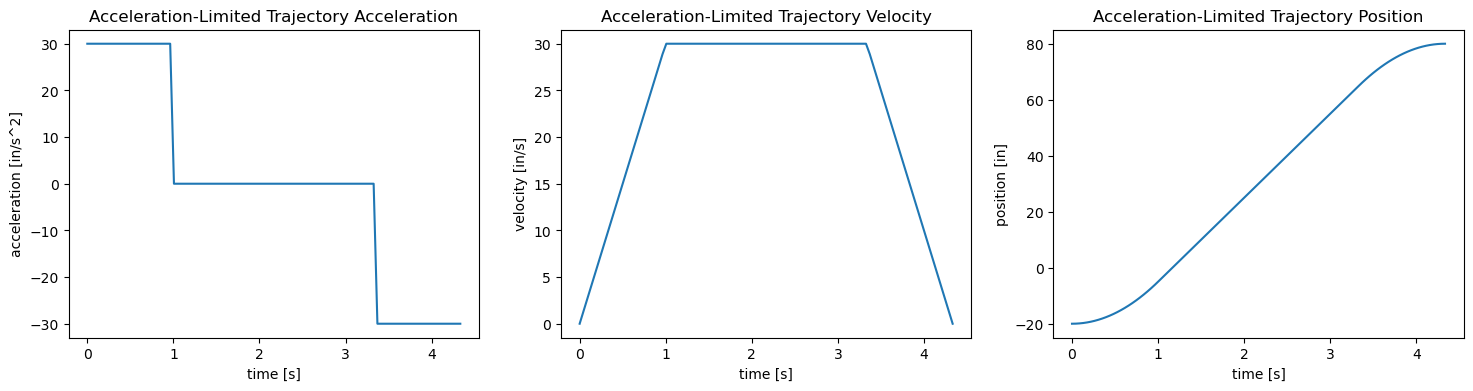

In [5]:
traj = accel_traj_gen(-20, 80, 30, 30)

t = np.linspace(0, accel_traj_duration(traj), 100)

fig, ax = plt.subplots(1, 3, figsize=(18, 4))

ax[0].set_title('Acceleration-Limited Trajectory Acceleration')
ax[0].set_xlabel('time [s]')
ax[0].set_ylabel('acceleration [in/s^2]')
ax[0].plot(t, accel_traj_get_accel(traj, t))

ax[1].set_title('Acceleration-Limited Trajectory Velocity')
ax[1].set_xlabel('time [s]')
ax[1].set_ylabel('velocity [in/s]')
ax[1].plot(t, accel_traj_get_vel(traj, t))

ax[2].set_title('Acceleration-Limited Trajectory Position')
ax[2].set_xlabel('time [s]')
ax[2].set_ylabel('position [in]')
ax[2].plot(t, accel_traj_get_pos(traj, t))

Try adjusting the parameters to get a degenerate trajectory with only two segments.

## Splines

But we want our robot to travel in more than just straight lines. We can use a sequence of polynomials called a spline to create a windy path that skirts around obstacles. Each segment of a 2D cubic spline has the form
\begin{align*}
    x(u) &= a_x u^3 + b_x u^2 + c_x u + d_x\\
    y(u) &= a_y u^3 + b_y u^2 + c_y u + d_y
\end{align*}
where $0 \leq u \leq 1$. To make sure the curve hits specific start and end coordinates, we impose the constraints
\begin{align*}
    x(0) &= x_0 & x(1) &= x_1\\
    y(0) &= y_0 & y(1) &= y_1.
\end{align*}
And now the extra flexibility of the spline enables us to specify the begin and end tangents, $(x'_0, y'_0)$ and $(x'_1, y'_1)$. These requirements give the derivative constraints
\begin{align*}
    x'(0) &= x'_0 & x'(1) &= x'_1\\
    y'(0) &= y'_0 & y'(1) &= y'_1.
\end{align*}
By this point you may have noticed that $x$ and $y$ seem independent and can be computed separately. Let's consider the $x$ one and suppress the subscripts on the coefficients. The derivative is
$$
    x'(u) = 3 a u^2 + 2 b u + c.
$$
Evaluating all of the constraints, we obtain the system of equations
\begin{align*}
    x_0 &= d\\
    x'_0 &= c\\
    x_1 &= a + b + c + d\\
    x'_1 &= 3a + 2b + c.
\end{align*}
As an exercise, you can verify that the solution is 
\begin{align*}
    a &= 2x_0 + x'_0 - 2x_1 + x'_1\\
    b &= -3x_0 - 2x'_0 + 3x_1 - x'_1\\
    c &= x'_0\\
    d &= x_0.
\end{align*}

Now we can write methods to fit spline parameters and give spline values and derivatives.

In [6]:
def spline_fit(x0, dx0, x1, dx1):
    a = 2 * x0 + dx0 - 2 * x1 + dx1
    b = -3 * x0 - 2 * dx0 + 3 * x1 - dx1
    c = dx0
    d = x0
    return a, b, c, d

def spline_get(spline, u):
    a, b, c, d = spline
    return a * u**3 + b * u**2 + c * u + d

def spline_deriv(spline, u):
    a, b, c, d = spline
    return 3 * a * u**2 + 2 * b * u + c

Let's give this a quick test.

0 36 24 30
0 -24 24 -9


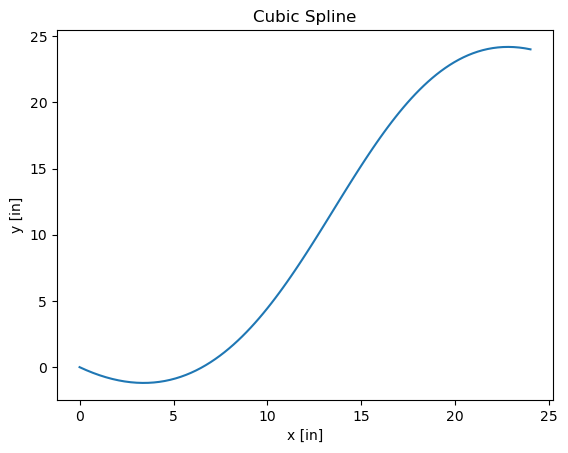

In [7]:
x_spline = spline_fit(0, 36, 24, 30)
y_spline = spline_fit(0, -24, 24, -9)
u = np.linspace(0, 1, 100)

plt.title('Cubic Spline')
plt.xlabel('x [in]')
plt.ylabel('y [in]')

plt.plot(spline_get(x_spline, u), spline_get(y_spline, u))

print(spline_get(x_spline, 0), spline_deriv(x_spline, 0), spline_get(x_spline, 1), spline_deriv(x_spline, 1))
print(spline_get(y_spline, 0), spline_deriv(y_spline, 0), spline_get(y_spline, 1), spline_deriv(y_spline, 1))

We have a spline now, and we just need to marry it with a trajectory. The general idea is to compute a trajectory for the displacement along the spline and compose the two. But we only have the spline as a function of an arbitrary parameter instead of displacement. Put differently, we're missing a function $u(s)$ to compose in between.

A handy integral gives the displacement as a function of $u$
$$
    s(u) = \int_0^u \sqrt{\left( \frac{dx}{d\upsilon} \right)^2 + \left( \frac{dy}{d\upsilon} \right)^2} \, d\upsilon.
$$
While we can't easily invert the integral analytically, we can write code to compute indvidual values. Recalling Riemann sums, integrals can be numerically approximated by adding up small rectangular areas. We can compute the $u$-value corresponding to a given displacement $s$ by tracking the running total and stopping when we reach $s$.

In [8]:
upsilon = np.linspace(0, 1, 100)
dupsilon = upsilon[1] - upsilon[0]
integrand = np.sqrt(
    spline_deriv(x_spline, upsilon)**2 + 
    spline_deriv(y_spline, upsilon)**2
)

sums = np.zeros_like(upsilon)
last_sum = 0
for i in range(len(upsilon)):
    sums[i] = last_sum + integrand[i] * dupsilon
    last_sum = sums[i]
    
    
@np.vectorize
def spline_param_of_disp(s):
    for i in range(len(sums)):
        if s < sums[i]:
            return upsilon[i]

Now we put everything together and generate a trajectory for the spline!

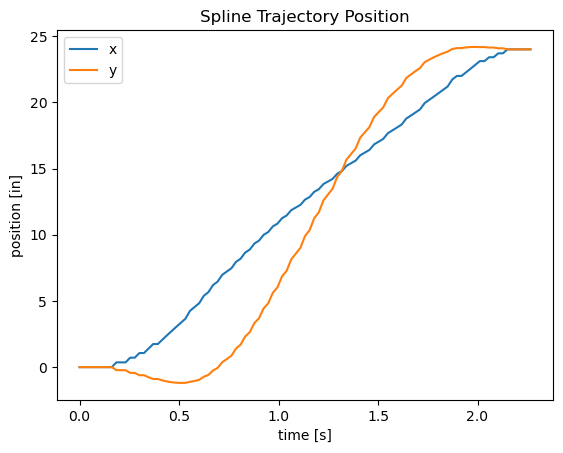

In [9]:
length = sums[-1]
traj = accel_traj_gen(0, length, 30, 30)
t = np.linspace(0, accel_traj_duration(traj), 100)

s = accel_traj_get_pos(traj, t)

u = spline_param_of_disp(s)

x = spline_get(x_spline, u)
y = spline_get(y_spline, u)

plt.title('Spline Trajectory Position')
plt.xlabel('time [s]')
plt.ylabel('position [in]')
plt.plot(t, x, label='x')
plt.plot(t, y, label='y')
plt.legend()

Each component of the trajectory is the composition of three functions: $(x(u(s(t))), y(u(s(t))))$. We can find the velocity by differentiating with respect to $t$. For the $x$-component, this gives
\begin{align*}
    x'(t) &= \frac{d}{dt} x(u(s(t))))\\
    &= x'(u(s(t)) \, u'(s(t)) \, s'(t).
\end{align*}
The only derivative we're missing is $u'(s)$. More chain rule abuse yields
\begin{align*}
    u'(s) &= [s'(u)]^{-1}\\
    &= \left[\frac{d}{du} \int_0^u \sqrt{\left( \frac{dx}{d\upsilon} \right)^2 + \left( \frac{dy}{d\upsilon} \right)^2} \, d\upsilon \right]^{-1}\\
    &= \left[\sqrt{\left( \frac{dx}{du} \right)^2 + \left( \frac{dy}{du} \right)^2}\right]^{-1}.
\end{align*}

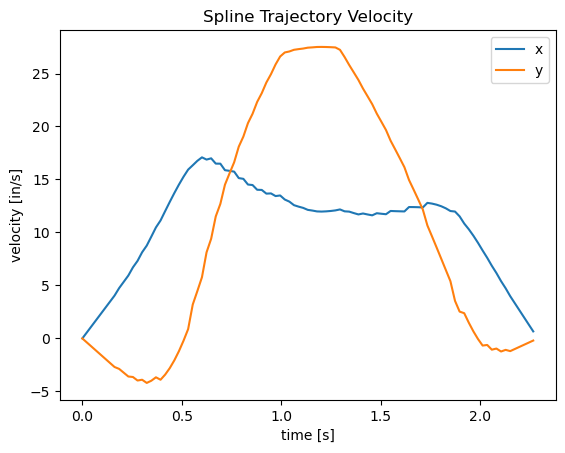

In [10]:
def spline_param_of_disp_deriv(x_spline, y_spline, u):
    return 1.0 / np.sqrt(spline_deriv(x_spline, u)**2 + spline_deriv(y_spline, u)**2)


dsdt = accel_traj_get_vel(traj, t)

duds = spline_param_of_disp_deriv(x_spline, y_spline, u)

dxdu = spline_deriv(x_spline, u)
dydu = spline_deriv(y_spline, u)

dxdt = dxdu * duds * dsdt
dydt = dydu * duds * dsdt


plt.title('Spline Trajectory Velocity')
plt.xlabel('time [s]')
plt.ylabel('velocity [in/s]')
plt.plot(t, dxdt, label='x')
plt.plot(t, dydt, label='y')
plt.legend()

Try computing the spline trajectory acceleration as an advanced exercise.